# Time Series Analysis of Real Estate Prices in San Jose, CA


### Lynn Anderson

# Overview

The aim of this project was to use Time Series forecasting to predict which zip codes in San Jose, CA are most likely to provide the highest return on investment in the next 5 years. TS models are .........t is a series of observations taken at specified times basically at equal intervals. It is used to predict future values based on past observed values.




# Business Understanding


Bay Area Properties Group is a Real Estate investment company looking to invest in the San Jose area. Many tech start ups are based in this location, and there is lkely to be a demand for property in the future. Therefore, in order to make wise investment decisions, they want to know the top 5 zipcodes predicted to provide the highest return on investment.

# Data Understanding

The dataset consisted of a csv file obtained from Zillow Housing dataset. The original dataset consisted of records from 342,535,353 zip codes across all 50 states, and covered April 1996- April, 2018. The data used in this project only looked at zip codes in the San Jose metro area. Additionally, to minimize the effects of the 2008 crash and model for recent trends, data from 2012 onwards was used for modeling.



# Data Preparation

In [8]:
 !pip install pmdarima

In [156]:
!pip install prophet

     -------------------------------------- 13.3/13.3 MB 593.3 kB/s eta 0:00:00
  Using cached importlib_resources-6.1.0-py3-none-any.whl (33 kB)
     ------------------------------------ 801.0/801.0 kB 588.8 kB/s eta 0:00:00
     -------------------------------------- 93.0/93.0 kB 587.2 kB/s eta 0:00:00


In [158]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.arima import auto_arima
import math
from prophet import Prophet



warnings.simplefilter("ignore", ConvergenceWarning)

%matplotlib inline

In [10]:
# load csv file into dataframe
df = pd.read_csv("data/zillow_data.csv")
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [11]:
df["State"].value_counts()

CA    1224
NY    1015
TX     989
PA     831
FL     785
OH     588
IL     547
NJ     502
MI     499
IN     428
NC     428
MA     417
TN     404
VA     401
MN     375
GA     345
WA     341
WI     332
MO     319
MD     317
CO     249
KS     241
AZ     230
OR     224
OK     221
SC     206
NH     199
LA     193
AL     183
IA     158
MS     153
KY     139
CT     124
UT     121
ID     110
AR     105
NV     103
ME      86
NE      83
WV      72
MT      71
HI      62
NM      60
RI      59
DE      41
ND      31
WY      31
AK      28
SD      19
DC      18
VT      16
Name: State, dtype: int64

In [12]:
df['State'].nunique()

51

#### Dataframe with just data for San Jose, CA

In [15]:
san_jose = df.loc[(df['Metro'] == 'San Jose')]
san_jose.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
244,97991,95123,San Jose,CA,San Jose,Santa Clara,245,224500.0,224800.0,225200.0,...,879400,894700,911900,931300,951900,970700,986100,1002200,1025400,1043900
289,97952,95051,Santa Clara,CA,San Jose,Santa Clara,290,258700.0,259300.0,259900.0,...,1252800,1287100,1326800,1365400,1405600,1444500,1476800,1508100,1547700,1577100
363,97940,95035,Milpitas,CA,San Jose,Santa Clara,364,231100.0,232100.0,233100.0,...,970900,982600,1000200,1021900,1045000,1063700,1076600,1096500,1131900,1160700
461,97926,95014,Cupertino,CA,San Jose,Santa Clara,462,432400.0,434500.0,436700.0,...,2099800,2135500,2181900,2235300,2291500,2336900,2374400,2416300,2464200,2490200
513,97980,95112,San Jose,CA,San Jose,Santa Clara,514,186800.0,186800.0,186700.0,...,738000,754200,772700,791600,812500,834100,852200,871200,896300,916100


In [16]:
san_jose['CountyName'].value_counts()

Santa Clara    52
San Benito      3
Name: CountyName, dtype: int64

In [17]:
san_jose['RegionName'].value_counts()

95123    1
94022    1
95148    1
95118    1
95032    1
95117    1
95121    1
95131    1
95133    1
95054    1
94089    1
94024    1
94301    1
95135    1
94306    1
94041    1
95110    1
95138    1
95030    1
95130    1
94305    1
95033    1
95119    1
95046    1
95139    1
95045    1
95132    1
95070    1
95051    1
95127    1
95035    1
95014    1
95112    1
94087    1
95125    1
94086    1
95008    1
95020    1
95124    1
95037    1
95136    1
95111    1
95122    1
95023    1
94040    1
95050    1
95126    1
94303    1
95129    1
95128    1
95134    1
94043    1
95116    1
95120    1
95004    1
Name: RegionName, dtype: int64

In [18]:
san_jose.duplicated().sum()

0

In [19]:
san_jose.isnull().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
             ..
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 272, dtype: int64

In [20]:
san_jose.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 244 to 11894
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 117.3+ KB


In [22]:
san_jose.isnull().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
             ..
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 272, dtype: int64

In [23]:
san_jose['RegionName'].nunique()

55

In [24]:
san_jose['City'].nunique()

19

In [25]:
san_jose['Metro'].nunique()

1

In [250]:
san_jose['2018-04'].median()

1368000.0

In [251]:
san_jose['2018-04'].describe()

count    5.500000e+01
mean     1.661938e+06
std      9.639275e+05
min      5.096000e+05
25%      1.045750e+06
50%      1.368000e+06
75%      2.092800e+06
max      4.818400e+06
Name: 2018-04, dtype: float64

In [252]:
san_jose = san_jose[san_jose['2018-04']<=2e6]


In [253]:
san_jose['2018-04'].describe()

count    4.000000e+01
mean     1.165880e+06
std      3.267753e+05
min      5.096000e+05
25%      9.102500e+05
50%      1.165400e+06
75%      1.447325e+06
max      1.926800e+06
Name: 2018-04, dtype: float64

In [27]:
#df['ROI'] = (df['2018-04']/ df['1996-04'])-1
san_jose["%ROI"] = ((san_jose["2018-04"] / san_jose["2012-01"]) ** (1 / (2018-2012)) - 1) * 100
#san_jose_roi['roi_since12'] = (san_jose_roi['2018-04'] - san_jose_roi['2012-01'])/(san_jose_roi['2012-01'])
#san_jose_roi = san_jose_roi.sort_values('roi_since12',ascending=False)
san_jose["%ROI"].head()

san_jose.sort_values("%ROI",ascending=False).head(10)

C:\Users\lalyn\AppData\Local\Temp\ipykernel_14532\1184996382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  san_jose["%ROI"] = ((san_jose["2018-04"] / san_jose["2012-01"]) ** (1 / (2018-2012)) - 1) * 100


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,%ROI
5328,97551,94089,Sunnyvale,CA,San Jose,Santa Clara,5329,206600.0,207600.0,208600.0,...,1005100,1030600,1060800,1090100,1113200,1130100,1149300,1180300,1206600,20.309031
2580,97530,94043,Mountain View,CA,San Jose,Santa Clara,2581,291700.0,294000.0,296400.0,...,1745300,1779800,1812000,1847800,1881900,1915700,1965600,2031800,2074900,18.433032
582,97548,94086,Sunnyvale,CA,San Jose,Santa Clara,583,310400.0,312000.0,313800.0,...,1601000,1646500,1695300,1744100,1782000,1811300,1846200,1893700,1926800,17.609102
513,97980,95112,San Jose,CA,San Jose,Santa Clara,514,186800.0,186800.0,186700.0,...,754200,772700,791600,812500,834100,852200,871200,896300,916100,17.590781
1791,97527,94040,Mountain View,CA,San Jose,Santa Clara,1792,413200.0,416100.0,419200.0,...,2418700,2478700,2541700,2609400,2669000,2718200,2770500,2820300,2839500,17.503325
1856,97951,95050,Santa Clara,CA,San Jose,Santa Clara,1857,236900.0,238000.0,239300.0,...,1094000,1124500,1158400,1198500,1241100,1273200,1304400,1350200,1385100,17.330629
289,97952,95051,Santa Clara,CA,San Jose,Santa Clara,290,258700.0,259300.0,259900.0,...,1287100,1326800,1365400,1405600,1444500,1476800,1508100,1547700,1577100,17.285155
5738,97691,94301,Palo Alto,CA,San Jose,Santa Clara,5739,709500.0,711900.0,715000.0,...,4247600,4319300,4401100,4481700,4544700,4595100,4668700,4762600,4818400,17.132345
5325,97955,95054,Santa Clara,CA,San Jose,Santa Clara,5326,240200.0,241500.0,242900.0,...,1089200,1120200,1153000,1191900,1231900,1261600,1291700,1335300,1368000,16.978046
6345,97528,94041,Mountain View,CA,San Jose,Santa Clara,6346,339200.0,340400.0,341800.0,...,1887200,1937000,1986700,2038200,2085800,2122800,2157800,2210000,2254100,16.965311


In [ ]:
fig,ax=plt.subplots(figsize=(16,10))

#x_labels = bay_area_roi['RegionName']
x_labels = [str(a) for a in san_jose['RegionName']]
x = [str(a) for a, b in san_jose["RegionName"].iteritems()]
y = [a for a in san_jose.sort_values("%ROI",ascending=False)]
#for idx, zipcode in san_jose["RegionName"].iteritems():
 #   zip_code = df[df['RegionName']== zipcode]
ax.bar(x,y)

#ax.set_xticks(a for a in bay_area_roi['RegionName'].keys())
ax.set_xticklabels(x_labels, rotation = 90)
ax.set_yticks([a/10 for a in list(range(0,17,1))])
ax.set_yticklabels([str(a*10)+'%' for a in list(range(0,17,1))])
ax.set_ylabel('% Growth',fontsize='20')
ax.set_xlabel('Zipcodes',fontsize='20')
ax.set_title('Avg % Return on Investment',fontsize='30');

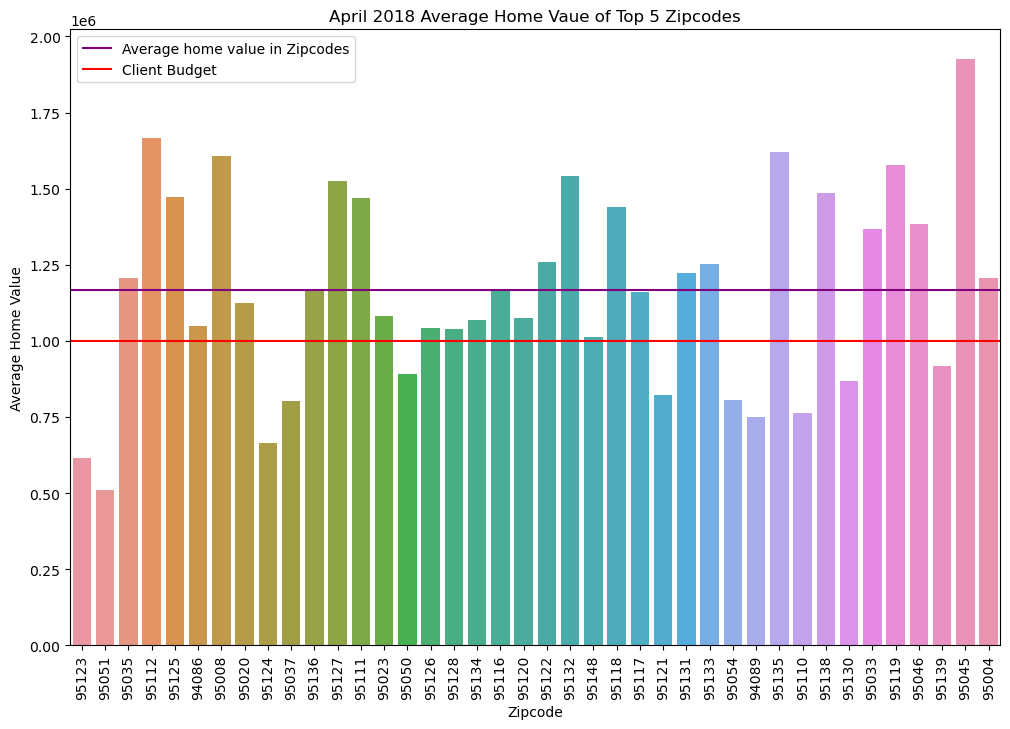

In [258]:



fig, ax = plt.subplots(figsize=(12, 8))
graph = sns.barplot(x=san_jose['%ROI'], y=san_jose['2018-04'], ax=ax)
graph.axhline(san_jose['2018-04'].mean(), color='purple', label='Average home value in Zipcodes')
graph.axhline(1e6, color='red', label='Client Budget')
ax.set_title('April 2018 Average Home Vaue of Top 5 Zipcodes')
ax.set_ylabel('Average Home Value')
ax.set_xlabel('Zipcode')
x_labels = [str(a) for a in san_jose['RegionName']]
ax.set_xticklabels(x_labels, rotation = 90)
ax.legend(loc='best');

In [250]:
san_jose['2018-04'].median()

1368000.0

In [251]:
san_jose['2018-04'].describe()

count    5.500000e+01
mean     1.661938e+06
std      9.639275e+05
min      5.096000e+05
25%      1.045750e+06
50%      1.368000e+06
75%      2.092800e+06
max      4.818400e+06
Name: 2018-04, dtype: float64

def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

# Data Visualization

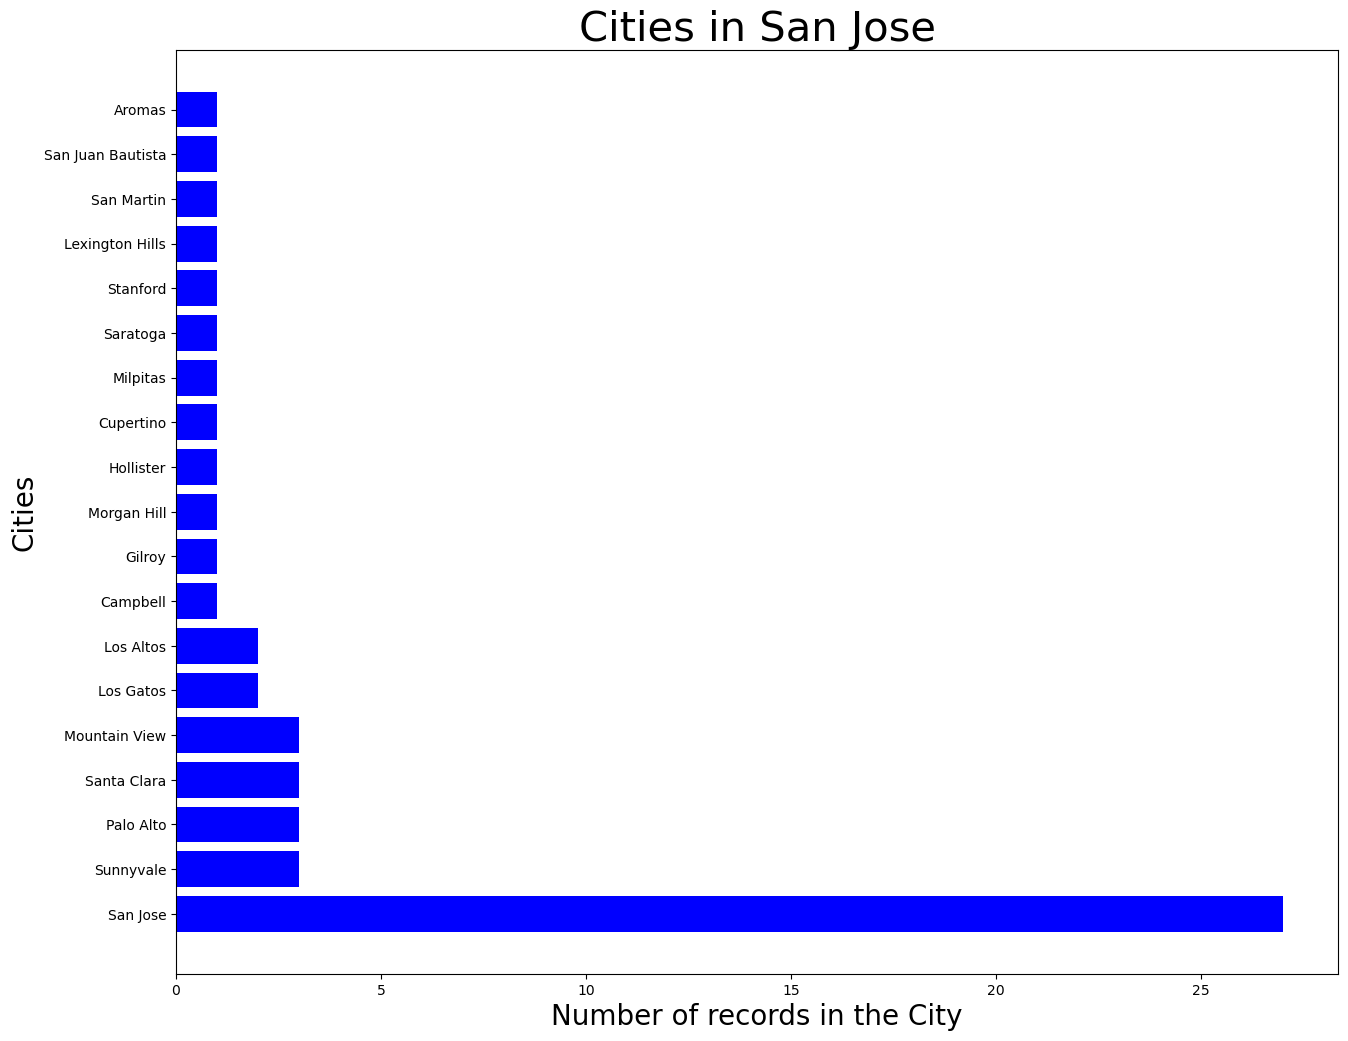

In [29]:
#Visualizing the value counts of zipcodes in each city in the Miami-Dade county

fig, ax = plt.subplots(figsize=(15,12))

y = [a for a in san_jose['City'].value_counts()]

x = [a for a in san_jose['City'].value_counts().keys()]

ax.barh(x,y,color='blue')
ax.set_title('Cities in San Jose',fontsize=30)
ax.set_ylabel('Cities',fontsize=20)
ax.set_xlabel('Number of records in the City',fontsize=20);

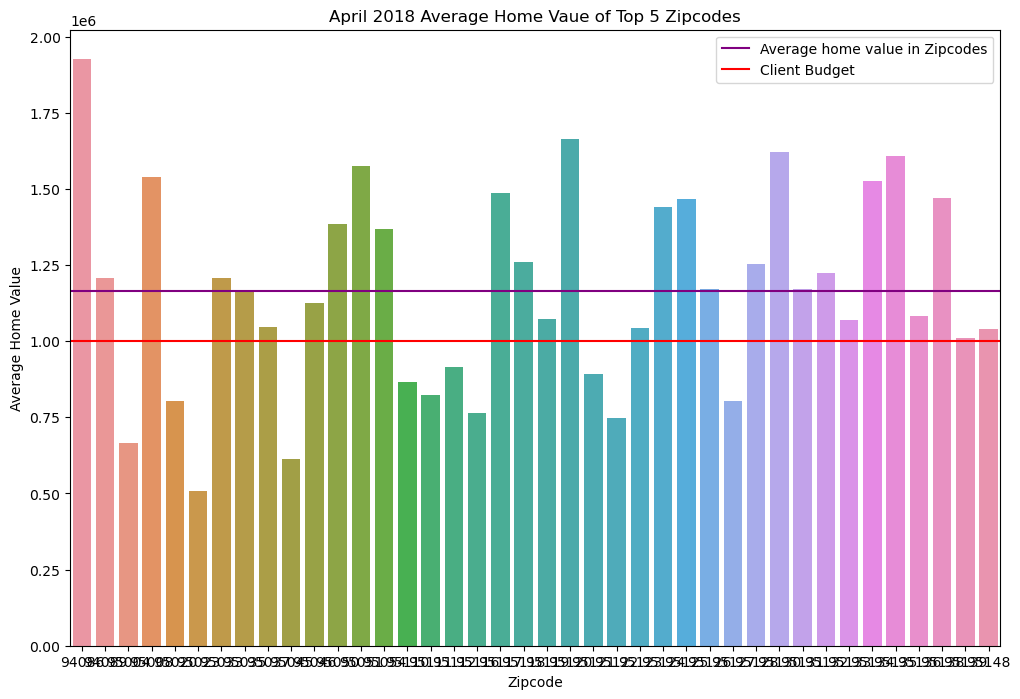

In [254]:
fig, ax = plt.subplots(figsize=(12, 8))
graph = sns.barplot(x=san_jose['RegionName'], y=san_jose['2018-04'], ax=ax)
graph.axhline(san_jose['2018-04'].mean(), color='purple', label='Average home value in Zipcodes')
graph.axhline(1e6, color='red', label='Client Budget')
ax.set_title('April 2018 Average Home Vaue of Top 5 Zipcodes')
ax.set_ylabel('Average Home Value')
ax.set_xlabel('Zipcode')
ax.legend(loc='best');


### Data exploration with the highest ROI zipcode, 94089

### function to Reshape wide to long

In [119]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', '%ROI', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [120]:
#Dataframe containining historical prices of the Zip Code.

zip94089 = san_jose[san_jose['RegionName']==94089]

# Time Series dataframe of Zip Code prices

series94089 = melt_data(zip94089)

series94089

,value
time,
1996-04-01,206600.0
1996-05-01,207600.0
1996-06-01,208600.0
1996-07-01,209600.0
1996-08-01,210600.0
...,...
2017-12-01,1113200.0
2018-01-01,1130100.0
2018-02-01,1149300.0


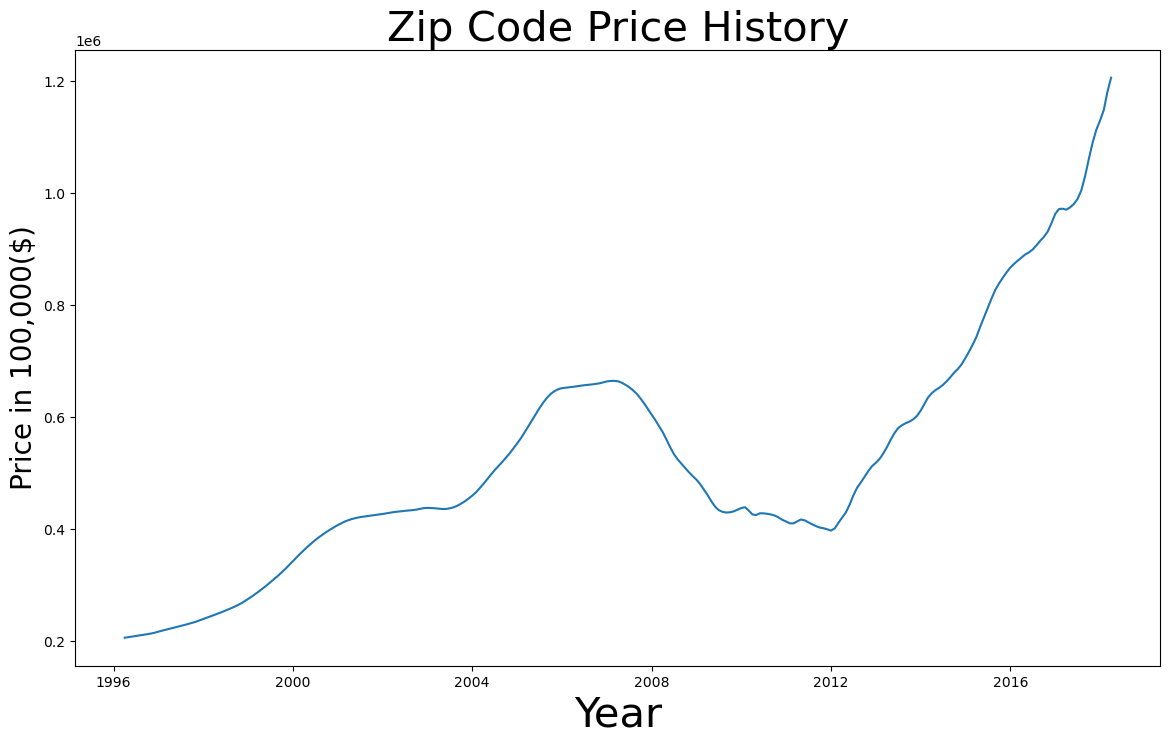

In [32]:
#Visualizing our Time Series Data for zipcode- 33126

fig, ax = plt.subplots(figsize=(14,8))
ax.plot(series94089)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20)
ax.set_title('Zip Code Price History',fontsize=30);

In [33]:
series94089.isnull().sum()

value    0
dtype: int64

In [34]:
"""year_groups = series94089.groupby(pd.Grouper(freq ='A'))
# Create a new DataFrame and store yearly values in columns 
df_annual = pd.DataFrame()

for yr, group in year_groups:
    df_annual[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
df_annual.plot(figsize = (13,8), subplots=True, legend=True);"""

"year_groups = series94089.groupby(pd.Grouper(freq ='A'))\n# Create a new DataFrame and store yearly values in columns \ndf_annual = pd.DataFrame()\n\nfor yr, group in year_groups:\n    df_annual[yr.year] = group.values.ravel()\n    \n# Plot the yearly groups as subplots\ndf_annual.plot(figsize = (13,8), subplots=True, legend=True);"

In [35]:
#df_annual.plot(figsize = (15,5), subplots=False, legend=True);


### Histogram

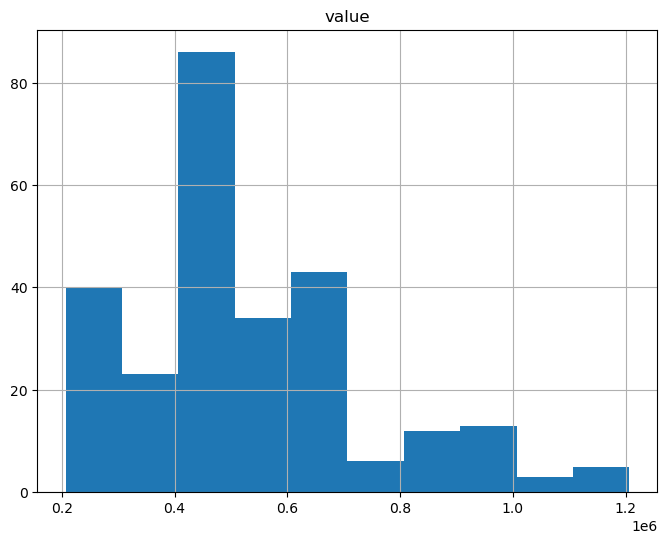

In [36]:
series94089.hist(figsize = (8,6));


### Boxplot

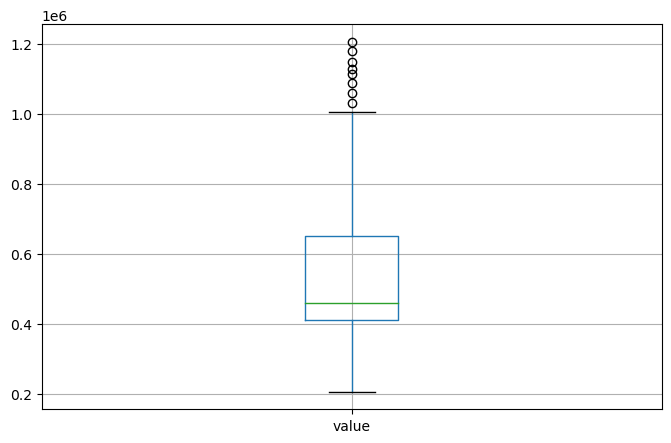

In [37]:
series94089.boxplot(figsize = (8,5));


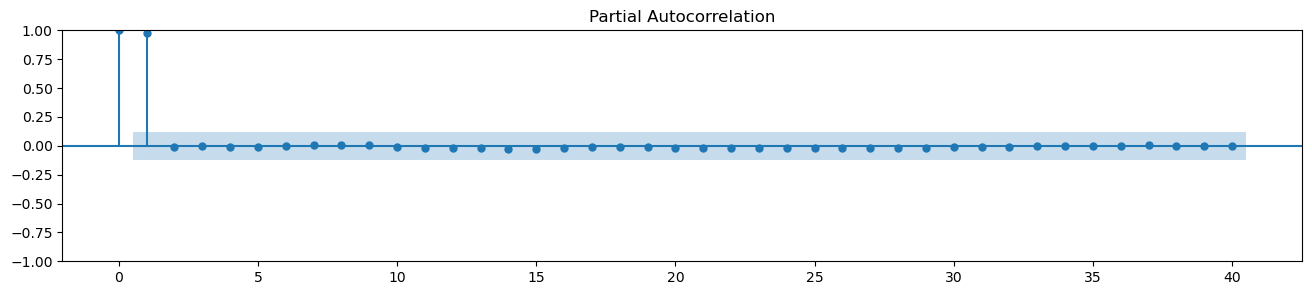

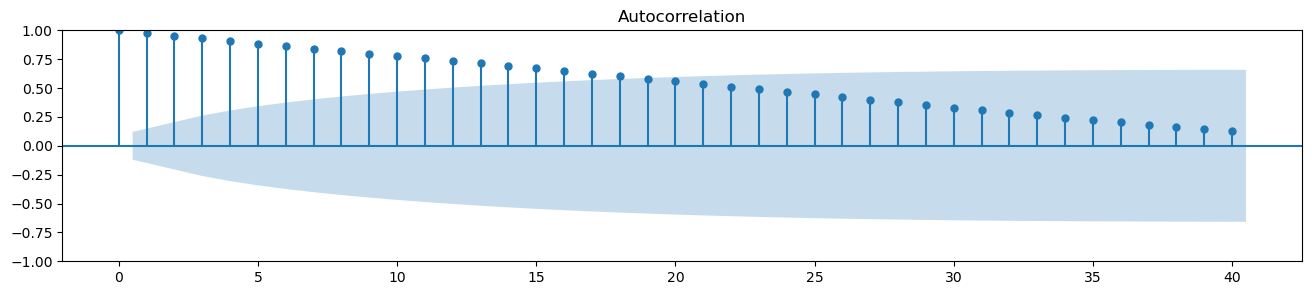

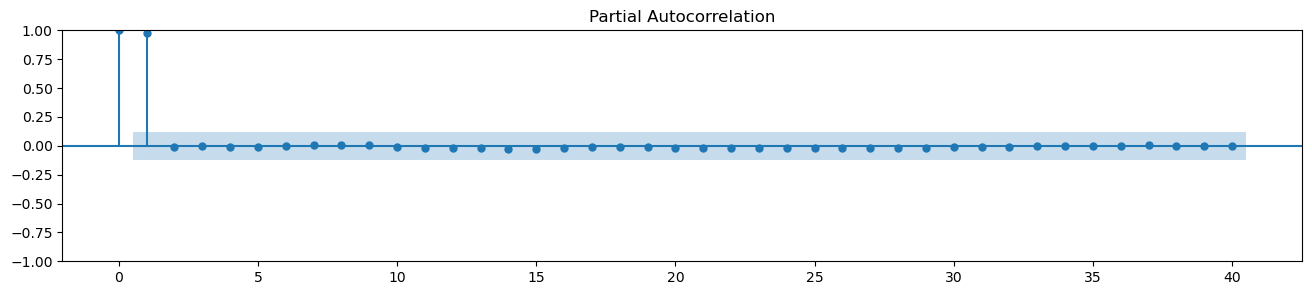

In [38]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(series94089, ax=ax, lags=40)

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(series94089, ax=ax, lags=40, method="ywm")

## Trends?

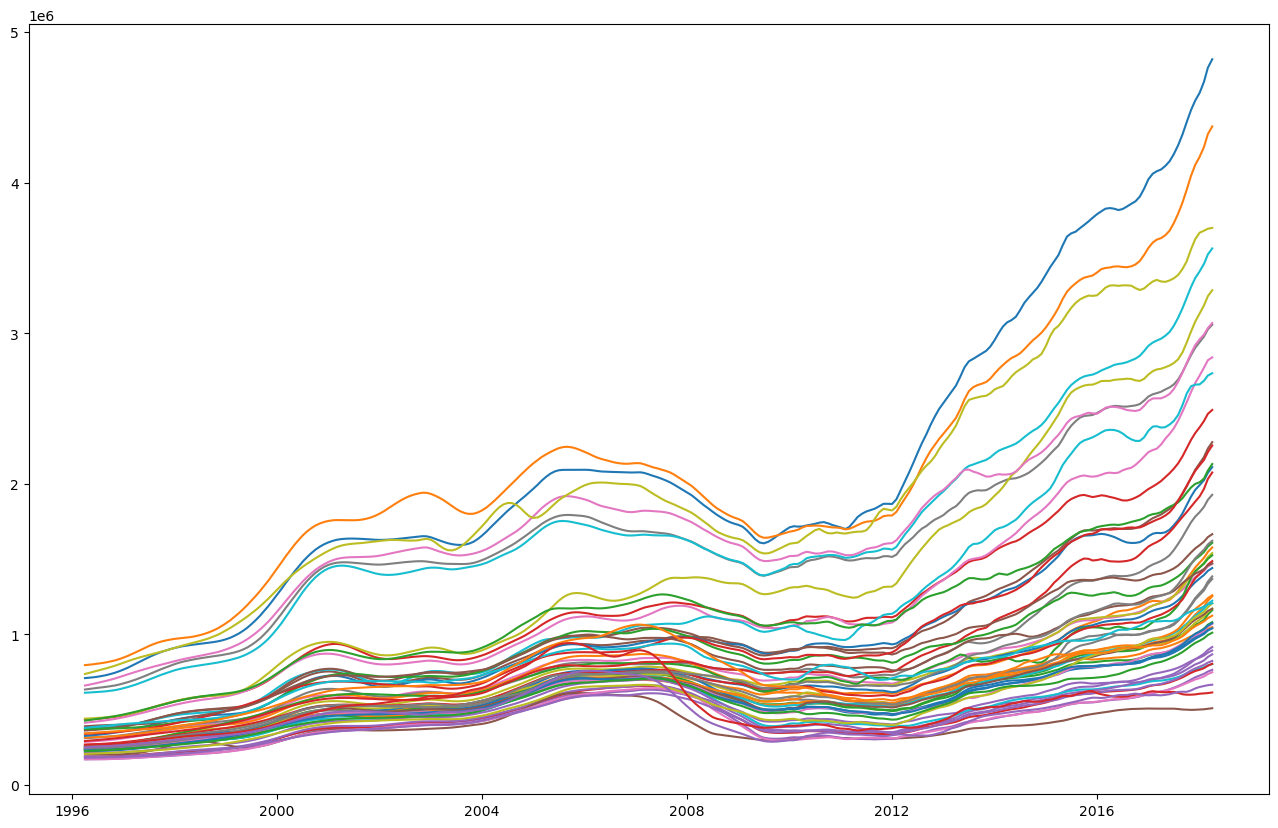

In [122]:
zip_dict = {}
sj_zips = [zipcode for idx, zipcode in san_jose["RegionName"].iteritems()]

    
# Time Series dataframe of Zip Code prices
for zipcode in sj_zips:
    zip_dict[zipcode] = melt_data(san_jose[san_jose['RegionName']==zipcode])
    
fig,ax = plt.subplots(figsize=(16,10))

for zipcode in zip_dict:
    ax.plot(zip_dict[zipcode]);


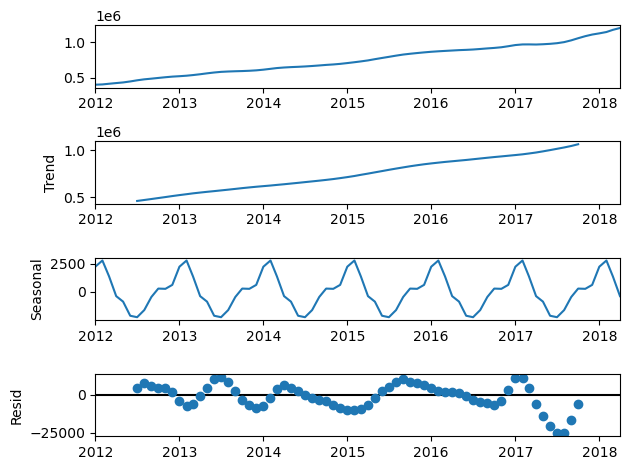

In [88]:
decompose_data = seasonal_decompose(recent_94089, model="additive")
decompose_data.plot();

In [41]:
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=4, center=False).mean()
    roll_std = TS.rolling(window=4, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['value'])
    
    # Plot rolling statistics:
    """fig = plt.figure(figsize=(8,5))
    plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)"""
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return dftest[1] < 0.05

In [42]:
stationarity_check(series94089)

Results of Dickey-Fuller Test: 

Test Statistic                   0.412844
p-value                          0.981969
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


False

### Slice series for recent data

In [43]:
recent_94089 = series94089['2012':]


In [44]:
recent_94089

,value
time,
2012-01-01,397900.0
2012-02-01,401800.0
2012-03-01,411400.0
2012-04-01,421100.0
2012-05-01,430100.0
...,...
2017-12-01,1113200.0
2018-01-01,1130100.0
2018-02-01,1149300.0


In [45]:
stationarity_check(recent_94089)

Results of Dickey-Fuller Test: 

Test Statistic                  1.443749
p-value                         0.997304
#Lags Used                     10.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


False

### Log of recent data

In [46]:
recent_log_ts_94089 = np.log(recent_94089)
stationarity_check(recent_log_ts_94089)

Results of Dickey-Fuller Test: 

Test Statistic                 -0.352200
p-value                         0.917779
#Lags Used                      6.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


False

In [47]:
recent_log_roll_mean_94089 = recent_log_ts_94089.rolling(window=5, center=False).mean()
recent_log_ts_rm_94089 = recent_log_ts_94089 - recent_log_roll_mean_94089
stationarity_check(recent_log_ts_rm_94089.dropna())

Results of Dickey-Fuller Test: 

Test Statistic                 -3.463667
p-value                         0.008971
#Lags Used                      3.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64


True

In [48]:
recent_log_diff_94089 = recent_log_ts_94089.diff().dropna()

stationarity_check(recent_log_diff_94089)

Results of Dickey-Fuller Test: 

Test Statistic                 -3.633308
p-value                         0.005155
#Lags Used                      3.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


True

In [49]:
list_booleans = []
for idx, zipcode in san_jose["RegionName"].iteritems():
    zip_code = df[df['RegionName']== zipcode]
# Time Series dataframe of Zip Code prices
    print(zipcode)

    series = melt_data(zip_code)
    recent = series['2012':]
    recent_log_ts = np.log(recent)
    #recent_log_diff = recent_log_ts.diff().dropna()
    recent_log_roll_mean = recent_log_ts.rolling(window=5, center=False).mean()
    recent_log_ts_rm = recent_log_ts - recent_log_roll_mean
    result = stationarity_check(recent_log_ts_rm.dropna())
    list_booleans.append(result)

95123
Results of Dickey-Fuller Test: 

Test Statistic                 -1.863332
p-value                         0.349502
#Lags Used                      5.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64
95051
Results of Dickey-Fuller Test: 

Test Statistic                 -3.377821
p-value                         0.011739
#Lags Used                      8.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64
95035
Results of Dickey-Fuller Test: 

Test Statistic                 -2.219539
p-value                         0.199231
#Lags Used                      5.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2

Results of Dickey-Fuller Test: 

Test Statistic                 -1.824399
p-value                         0.368417
#Lags Used                      7.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64
95118
Results of Dickey-Fuller Test: 

Test Statistic                 -2.614570
p-value                         0.090023
#Lags Used                      8.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64
95032
Results of Dickey-Fuller Test: 

Test Statistic                 -2.253656
p-value                         0.187350
#Lags Used                      8.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.59189

In [50]:
list_booleans

[False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True]

### Train-test split

In [187]:
train_series = recent_94089[:'2016-04']
test_series = recent_94089['2016-04':]

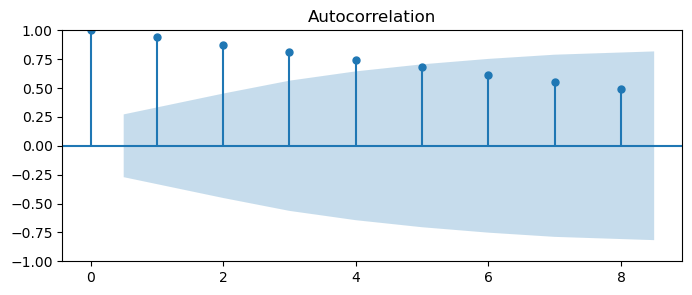

In [109]:
fig, ax = plt.subplots(figsize=(8, 3))
plot_acf(train_series, ax=ax, lags=8);

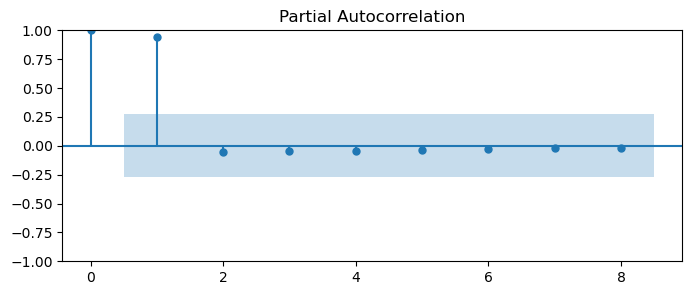

In [110]:
fig, ax = plt.subplots(figsize=(8, 3))
plot_pacf(train_series, ax=ax, lags=8, method="ywm");

# Modeling

An autoregressive (AR) model is when a value from a time series is regressed on previous values from the same time series.
The Moving Average model can be described as the weighted sum of today's and yesterday's noise.
That's where ARMA models come in, which basically means that in this model, a regression on past values takes place (AR part) and also that the error term is modeled as a linear combination of error terms of the recent past (MA part). 

In [170]:
# 1st order AR model

mod1_ar = ARIMA(recent_log_diff_94089, order=(1, 0, 0))
output_ar = mod1_ar.fit()

# Print out summary information on the fit
print(output_ar.summary())
pred = output.get_prediction(start=pd.to_datetime('2016-04'), end=pd.to_datetime('2018-04'), dynamic=False)
predicted = pred.predicted_mean

real = test_series.value
mse = mean_squared_error(real, np.exp(predicted))
mse = ((predicted - real) ** 2).mean()
rmse = math.sqrt(mse)
rmse

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   75
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 302.507
Date:                Wed, 25 Oct 2023   AIC                           -599.013
Time:                        18:37:36   BIC                           -592.061
Sample:                    02-01-2012   HQIC                          -596.237
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0148      0.003      4.650      0.000       0.009       0.021
ar.L1          0.8338      0.071     11.827      0.000       0.696       0.972
sigma2      1.806e-05    2.6e-06      6.941      0.0

C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Found input variables with inconsistent numbers of samples: [24, 25]

In [165]:
#1st order MA model

mod1_ma = ARIMA(recent_log_diff_94089, order=(0, 0, 1))
output_ma = mod1_ma.fit()

# Print out summary information on the fit
print(output_ma.summary())

C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   75
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 295.638
Date:                Wed, 25 Oct 2023   AIC                           -585.276
Time:                        18:04:44   BIC                           -578.324
Sample:                    02-01-2012   HQIC                          -582.500
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0147      0.001     13.427      0.000       0.013       0.017
ma.L1          0.8727      0.072     12.163      0.000       0.732       1.013
sigma2       2.16e-05   3.79e-06      5.693      0.0

## Auto ARIMA model

in the basic ARIMA model, we need to provide the p,d, and q values which are essential. We use statistical techniques to generate these values by performing the difference to eliminate the non-stationarity and plotting ACF and PACF graphs. In Auto ARIMA, the model itself will generate the optimal p, d, and q values which would be suitable for the data set to provide better forecasting. The ARIMA consists of an integrated moving average of autoregressive time series. 

In [179]:
auto_model = pm.auto_arima(train_series,
                            m=12,
                            seasonal=True,
                            start_p=0,
                            start_q=0,
                            start_P=0,
                            start_Q=0,
                            max_order=6, 
                            test='adf',
                            error_action='warn',  
                            suppress_warnings=True,
                            stepwise=True,
                            trace=False)
                           
print(auto_model.summary())



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -462.594
Date:                Wed, 25 Oct 2023   AIC                            929.188
Time:                        18:50:53   BIC                            933.051
Sample:                    01-01-2012   HQIC                           930.664
                         - 05-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0201      0.035     -0.581      0.561      -0.088       0.048
sigma2      3.609e+06   6.52e+05      5.535      0.000    2.33e+06    4.89e+06
Ljung-Box (L1) (Q):                  10.88   Jarque-

In [180]:
auto_model.order


(1, 2, 0)

In [181]:
auto_model.seasonal_order


(0, 0, 0, 12)

C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0200      0.035     -0.566      0.571      -0.089       0.049
sigma2      3.682e+06   6.83e+05      5.392      0.000    2.34e+06    5.02e+06


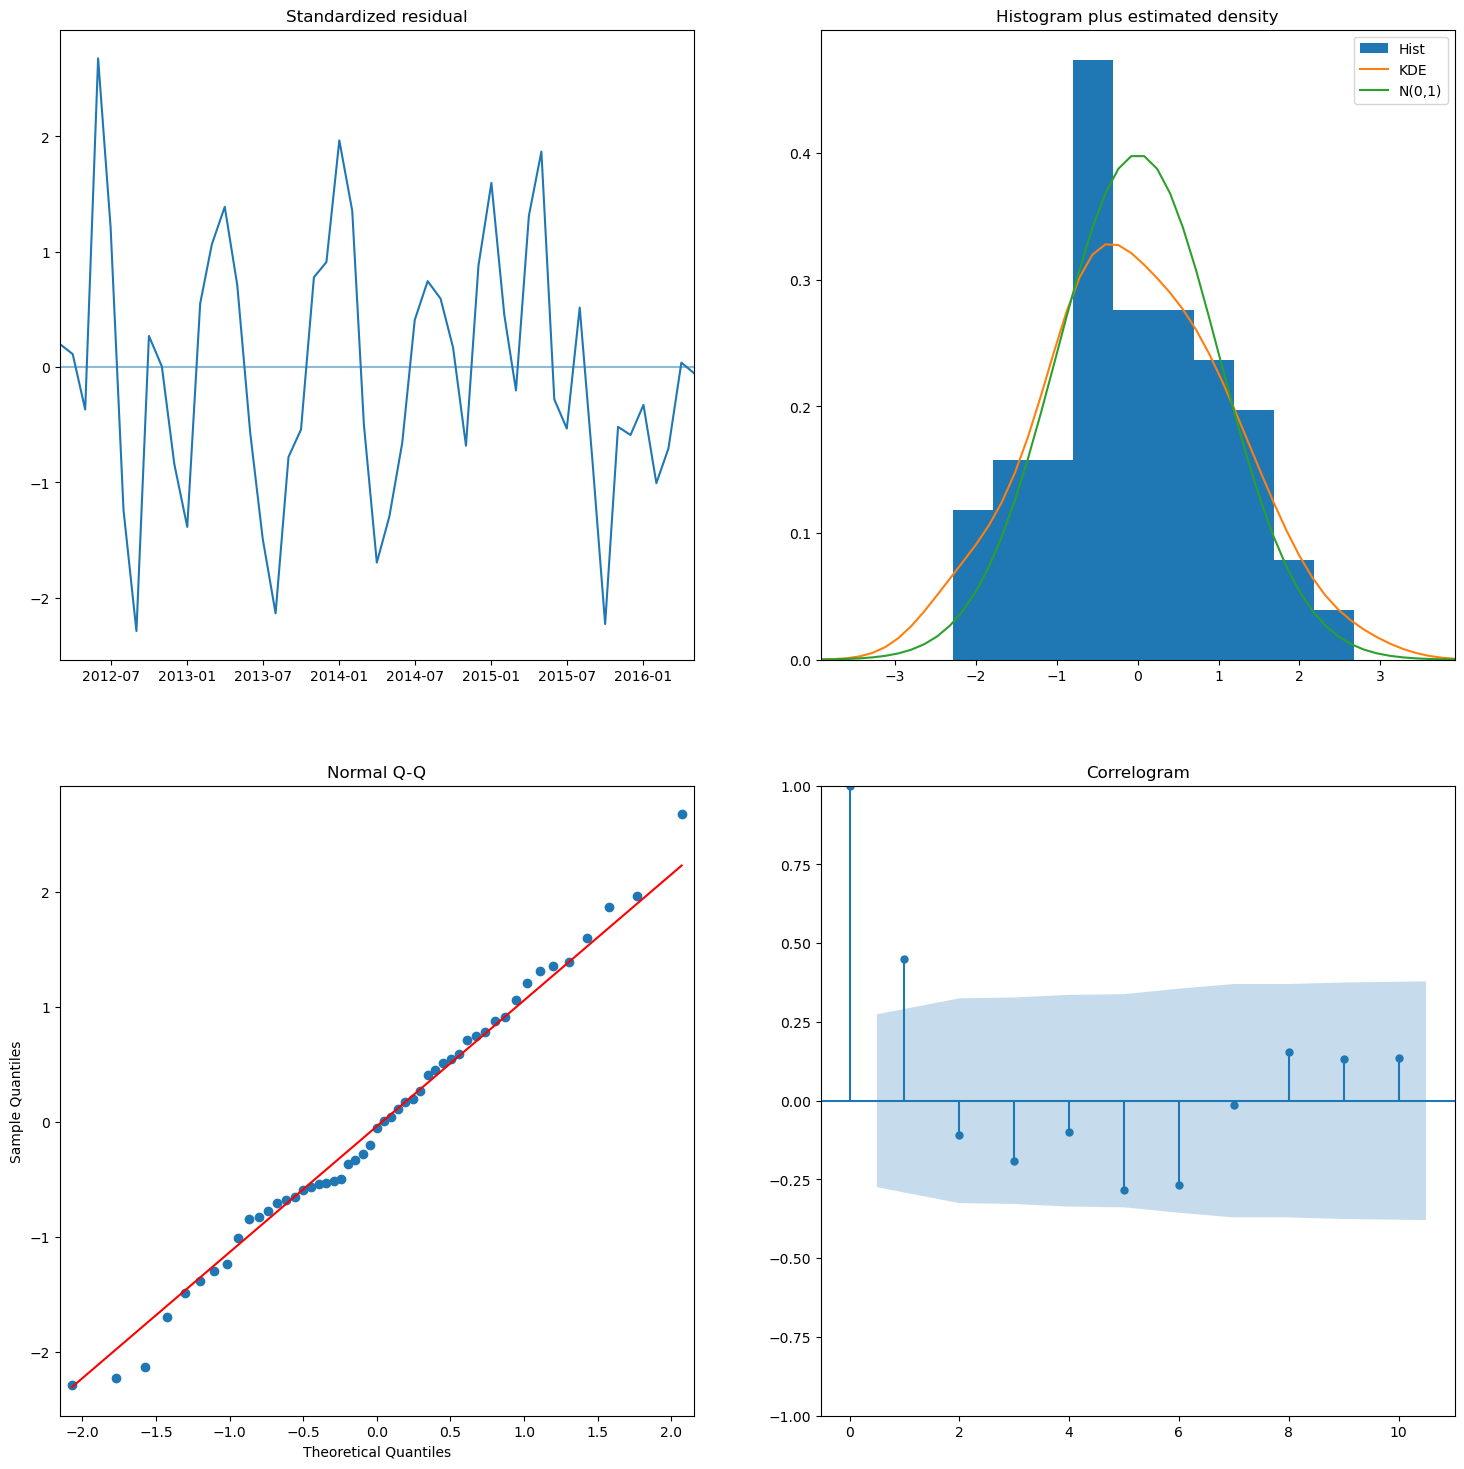

In [188]:
sarima_model = sm.tsa.statespace.SARIMAX(train_series, 
                                        order=(1,2,0), 
                                        seasonal_order=(0, 0, 0, 12), 
                                        enforce_stationarity=True, 
                                        enforce_invertibility=True)

# Fit the model and print results
output = sarima_model.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [189]:

pred = output.get_prediction(start=pd.to_datetime('2016-04'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf


,lower value,upper value
2016-04-01,881565.095039,8.890869e+05
2016-05-01,887237.120693,8.947589e+05
2016-06-01,888253.605062,9.049385e+05
2016-07-01,888281.541904,9.161066e+05
2016-08-01,887464.252691,9.281200e+05
2016-09-01,885898.750330,9.408816e+05
2016-10-01,883655.270356,9.543211e+05
2016-11-01,880787.517682,9.683850e+05
2016-12-01,877338.229657,9.830303e+05
2017-01-01,873342.446916,9.982222e+05


In [211]:
predicted = pred.predicted_mean
real = test_series.value
mse = mean_squared_error(real, predicted)
rmse = math.sqrt(mse)
rmse

73379.14380409155

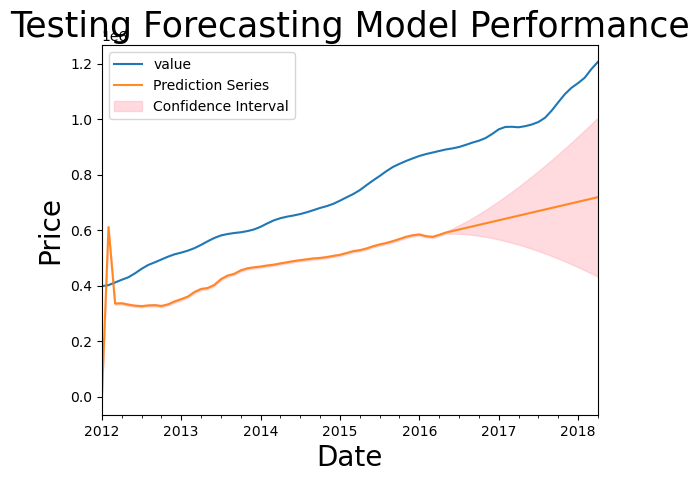

In [154]:
# Plot real vs predicted values along with confidence interval

# Plot observed values
ax = recent_94089.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Prediction Series', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='lightpink', alpha=0.5,label = 'Confidence Interval')

# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecasting Model Performance',fontsize=25)
plt.legend()

plt.show()

# Prophet model

In [201]:
df_pr = recent_94089.copy()
df_pr = recent_94089.reset_index()
df_pr.columns = ['ds','y'] # To use prophet column names should be like that
train_data_pr = df_pr.iloc[:len(df)-25]
test_data_pr = df_pr.iloc[len(df)-25:]
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=25,freq='MS')
prophet_pred = m.predict(future)
prophet_pred.tail()

19:01:59 - cmdstanpy - INFO - Chain [1] start processing
19:01:59 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
96,2020-01-01,1.457304e+06,1.410272e+06,1.506170e+06,1.412602e+06,1.500370e+06,2110.230226,2110.230226,2110.230226,2110.230226,2110.230226,2110.230226,0.0,0.0,0.0,1.459414e+06
97,2020-02-01,1.471804e+06,1.418416e+06,1.521160e+06,1.423411e+06,1.518058e+06,554.850781,554.850781,554.850781,554.850781,554.850781,554.850781,0.0,0.0,0.0,1.472358e+06
98,2020-03-01,1.485368e+06,1.432791e+06,1.538876e+06,1.434394e+06,1.534442e+06,2259.942596,2259.942596,2259.942596,2259.942596,2259.942596,2259.942596,0.0,0.0,0.0,1.487627e+06
99,2020-04-01,1.499867e+06,1.441882e+06,1.555901e+06,1.444988e+06,1.552733e+06,874.314502,874.314502,874.314502,874.314502,874.314502,874.314502,0.0,0.0,0.0,1.500741e+06
100,2020-05-01,1.513899e+06,1.450953e+06,1.569972e+06,1.454862e+06,1.570964e+06,-1589.176632,-1589.176632,-1589.176632,-1589.176632,-1589.176632,-1589.176632,0.0,0.0,0.0,1.512309e+06


In [202]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-25:]['ds'], "Pred" : prophet_pred[-25:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "MS"
prophet_pred

,Pred
Date,
2018-05-01,1.167566e+06
2018-06-01,1.181514e+06
2018-07-01,1.196049e+06
2018-08-01,1.212342e+06
2018-09-01,1.229718e+06
2018-10-01,1.246040e+06
2018-11-01,1.261796e+06
2018-12-01,1.276475e+06
2019-01-01,1.290298e+06


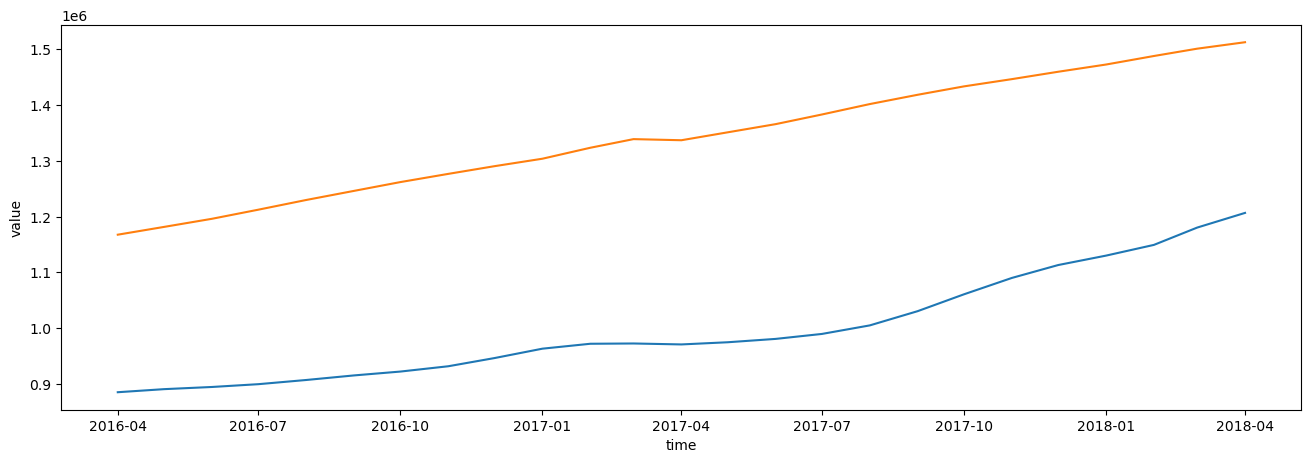

In [207]:
prophet_preds = prophet_pred['Pred'].values
import seaborn as sns
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_series.index, y=test_series.value)
sns.lineplot(x=test_series.index, y = prophet_preds);

In [210]:
#prophet_rmse_error = rmse(test_data['Monthly_Prod'], test_data["Prophet_Predictions"])
predicted = prophet_preds#.predicted_mean
real = test_series.value
mse = mean_squared_error(real, predicted)
rmse = math.sqrt(mse)
rmse


345769.5991242628

# Forecasting

In [217]:
model = sm.tsa.statespace.SARIMAX(recent_94089, 
                                        order=(1,2,0), 
                                        seasonal_order=(0, 0, 0, 12), 
                                        enforce_stationarity=True, 
                                        enforce_invertibility=True)

# Fit the model and print results
output2 = model.fit()
forecast = output2.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,lower,upper,prediction
2018-05-01,1.226716e+06,1.239217e+06,1.232966e+06
2018-06-01,1.245434e+06,1.273230e+06,1.259332e+06
2018-07-01,1.262497e+06,1.308898e+06,1.285697e+06
2018-08-01,1.278146e+06,1.345980e+06,1.312063e+06
2018-09-01,1.292544e+06,1.384313e+06,1.338428e+06
2018-10-01,1.305807e+06,1.423781e+06,1.364794e+06
2018-11-01,1.318027e+06,1.464292e+06,1.391159e+06
2018-12-01,1.329274e+06,1.505776e+06,1.417525e+06
2019-01-01,1.339607e+06,1.548174e+06,1.443891e+06
2019-02-01,1.349076e+06,1.591437e+06,1.470256e+06


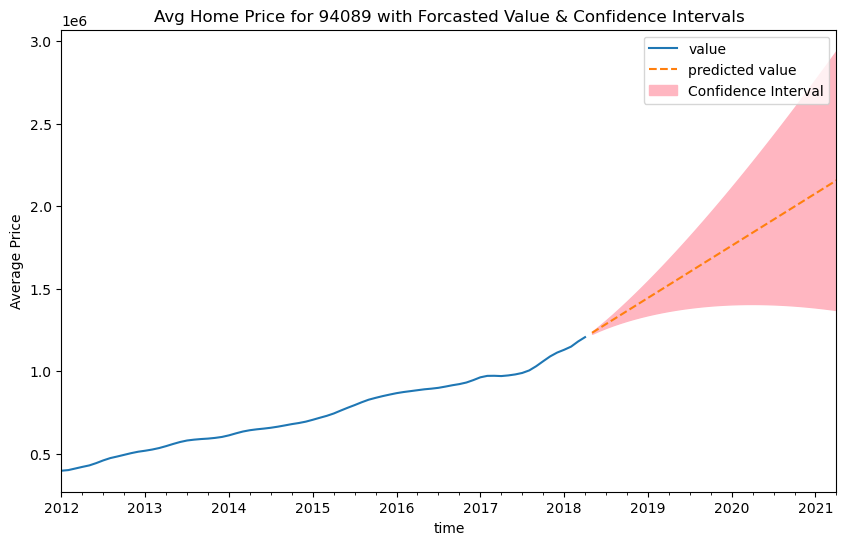

In [218]:
#Plotting our Forecast

fig, ax = plt.subplots(figsize=(10,6))
recent_94089.plot(ax=ax,label='Real Values')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='lightpink',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Avg Home Price for 94089 with Forcasted Value & Confidence Intervals')
plt.show()


#### For loop to iterate over zipcodes

In [225]:
results = []

for idx, zipcode in san_jose["RegionName"].iteritems():
    zip_code = san_jose[san_jose['RegionName']== zipcode]
    
    #Melting the time series of our given zipcode
    series = melt_data(san_jose[san_jose['RegionName']== zipcode])
    
    #Only taking data from 2012 onwards to more accurately reflect current market conditions
    recent_series = series['2012':]
    
    # Splitting the last 36 months of our series as a test dataset.
    train_series = recent_series[:'2016-04']
    test_series = recent_series['2016-05':]
    
    #Auto ARIMA model
    auto_model = pm.auto_arima(train_series,
                            m=12,
                            seasonal=True,
                            start_p=0,
                            start_q=0,
                            start_P=0,
                            start_Q=0,
                            max_order=6, 
                            test='adf',
                            error_action='ignore',  
                            suppress_warnings=True,
                            stepwise=True,
                            trace=False)
   
    # Plug the optimal parameter values for our Training data into a SARIMAX model that fits the series.
    sarima_model = sm.tsa.statespace.SARIMAX(recent_series, 
                                            order= auto_model.order, 
                                            seasonal_order= auto_model.seasonal_order)

    # Fit the model and print results
    output = sarima_model.fit()

    ## Getting a forecast for the next 5 years 
    forecast = output.get_forecast(36)
    prediction = forecast.conf_int()
    prediction['value'] = forecast.predicted_mean
    prediction.columns = ['lower','upper','prediction'] 
    
    #Adding the Zipcode's ROI to the zip_predictions dictionary
    
    three_year_ROI = round((prediction['prediction'][-1] - series['value'][-1])/ series['value'][-1], 2)
    
    results.append([zipcode, three_year_ROI])

C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\lalyn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provid

# Evaluation

# Conclusions

In [232]:
top_5_zipcodes

,Zipcode,3yrROI
17,95050,0.91
37,95054,0.86
21,95128,0.85
38,94089,0.79
32,95032,0.74


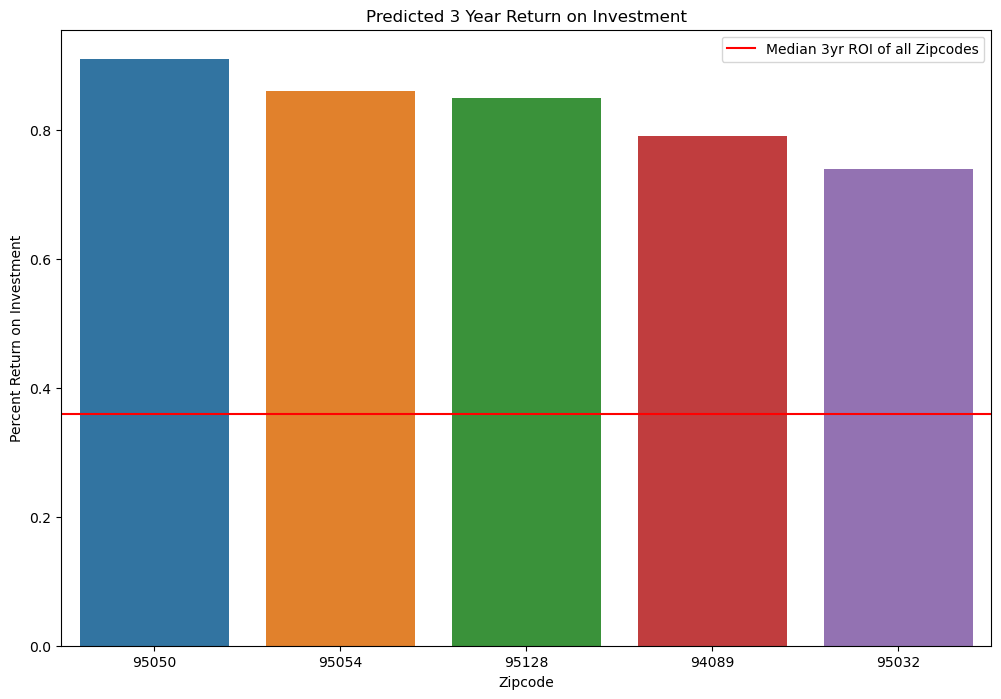

In [243]:
results = pd.DataFrame(results, columns=('Zipcode', '3yrROI'))
top_5_zipcodes = results.sort_values(by='3yrROI', ascending=False)[:5]


fig, ax = plt.subplots(figsize=(12, 8))
#graph = sns.barplot(x=top_5_zipcodes['Zipcode'], y=top_5_zipcodes['3yrROI'], ax=ax)
graph = sns.barplot(x='Zipcode', y='3yrROI', data= top_5_zipcodes,
                    order=top_5_zipcodes.sort_values('3yrROI',ascending = False).Zipcode, ax=ax)
graph.axhline(results['3yrROI'].median(), color='red', label='Median 3yr ROI of all Zipcodes')
ax.set_title('Predicted 3 Year Return on Investment')
ax.set_ylabel('Percent Return on Investment')
ax.legend();

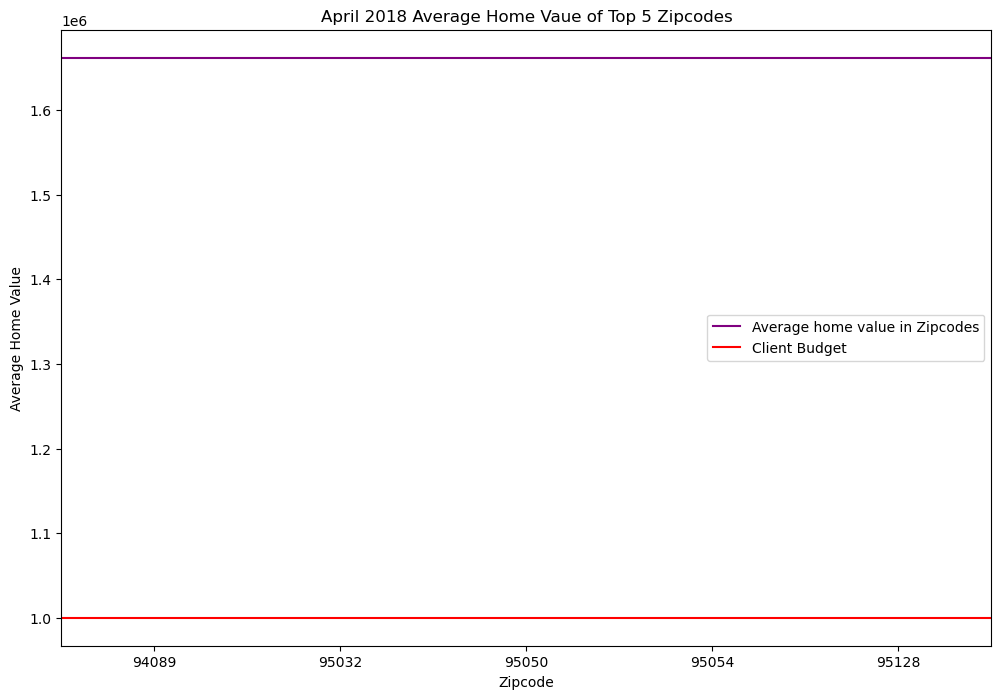

In [247]:
fig, ax = plt.subplots(figsize=(12, 8))
graph = sns.barplot(x=top_5_zipcodes['Zipcode'], y=san_jose['2018-04'], ax=ax)
graph.axhline(san_jose['2018-04'].mean(), color='purple', label='Average home value in Zipcodes')
graph.axhline(1e6, color='red', label='Client Budget')
ax.set_title('April 2018 Average Home Vaue of Top 5 Zipcodes')
ax.set_ylabel('Average Home Value')
ax.set_xlabel('Zipcode')
ax.legend(loc='best');

# Conclusions


# Next Steps and Limitations

Economic downturns are hard to predict and can have drastic influences on real estate prices. 
A limitation of this analysis that was encountered was the omission of resorts that were near cities not recorded or recognized in our Zillow dataset. This means that it is certainly possible for there to be additional zipcodes that fit our client's criteria that were not captured during our data filtering procedures. Finding a more robust dataset that contains zip codes and all of their associated cities/towns could help with this issue.

Exploring other exogenous features that contribute to the home value volatility of resort towns may help to better understand correlations within the data. These could include work-from-home opportunities, job markets, and weather.

The Zillow dataset used for this analysis had its most recent data points in April 2018. Finding more recent data will allow us to more accurately forecast future home value into 2025 and beyond.

# For More Information

See the full analysis in the [Jupyter Notebook](https://github.com/lalynjay/weather_classification/blob/main/weather_classification.ipynb) or review [this presentation](https://github.com/lalynjay/weather_classification/blob/main/weather_classification.pdf)

For additional info, contact Lynn Anderson at lalynjay@gmail.com

Repository Structure

├── data 

├── images

├── README.md

├── ts_presentation.pdf

└── notebook.ipynb